# Reasoning by Superposition: A Theoretical Perspective on Chain of Continuous Thought

This interactive notebook illustrates how the Coconut model leverages superposition states for reasoning. We visualize the attention patterns from the first and second transformer layers, and compute the inner products between continuous thoughts and node embeddings to reveal how information propagates and accumulates during inference.

In [1]:
# preparation
import argparse
from transformers import AutoModelForCausalLM, AutoConfig
import torch
from coconut import Coconut
from stokenizer import STokenizer
import matplotlib.pyplot as plt
import json
import random   
import numpy as np
from tqdm import tqdm

/data/shibo/anaconda3/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Loading the model

In [3]:
from huggingface_hub import hf_hub_download

print("loading weights")
checkpoint_path = hf_hub_download(
    repo_id="Shibo-UCSD/coconut-theory",
    filename="checkpoint_300"
)
saved_weights = torch.load(
    checkpoint_path, 
    map_location=torch.device("cuda:0")
)

loading weights


checkpoint_300:   0%|          | 0.00/60.2M [00:00<?, ?B/s]

In [4]:
# loading the model

tokenizer = STokenizer()
latent_id = tokenizer.convert_tokens_to_ids("<|latent|>")

model = AutoModelForCausalLM.from_config(
    AutoConfig.from_pretrained("configs/symbol-2layer-8head-768dim.json")
)
model = Coconut(model, latent_id, tokenizer.eos_token_id)
print(model.load_state_dict(saved_weights, strict=False))
print("evaluating")
model.eval()
model.base_causallm.to("cuda:0")

<All keys matched successfully>
evaluating


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(40, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=40, bias=False)
)

## First Layer Attention

According to our theoretical construction, the most important function of LAYER 1 attention heads is to copy the source and target node tokens of an edge onto the corresponding edge
token ⟨e⟩. The following code block presents a representative attention map, confirming that the model has instantiated this copying mechanism in practice.

In [5]:
inputs = "<eos> 5 15 | 11 16 | 1 3 | 14 17 | 0 14 | 1 8 | 0 9 | 0 5 | 15 16 | 3 4 | 19 20 | 3 7 | 7 20 | 9 17 | 0 15 | 9 10 | 14 16 | 10 12 | 2 6 | 4 8 | 5 9 | 8 19 | 7 13 | 7 11 | 7 8 | 5 21 | 1 12 | 16 22 | 3 8 | 0 10 | 5 18 | 13 22 | 5 10 | 7 22 [Q] 20 18 [R] 1 <|latent|>"
input_ids = tokenizer.encode(inputs, add_special_tokens=False)
input_ids = torch.tensor(input_ids).unsqueeze(0).cuda(0)
attention_mask = torch.ones_like(input_ids).cuda(0)
labels = torch.full_like(input_ids, -100).cuda(0)
position_ids = torch.arange(input_ids.shape[1]).unsqueeze(0).cuda(0)
outputs = model(input_ids, attention_mask, labels, position_ids)

latent_indices = (
    input_ids == model.latent_token_id
).nonzero()  # (num_latent_tokens_in_the_batch, 2)

latent_lists = [
    [idx[1].item() for idx in latent_indices if idx[0] == i]
    for i in range(input_ids.shape[0])
]  # bs, num_latent_tokens_in_the_instance (difference across the batch)

max_n_latents = max([len(l) for l in latent_lists])

next_compute_range = (0, input_ids.shape[1])
inputs_embeds = model.embedding(input_ids)
logits = []

if max_n_latents > 0:
    next_compute_range = (0, latent_indices[:, 1].min().item())
    # before the earliest latent token position

kv_cache = None

for pass_idx in range(max_n_latents):

    if kv_cache == None:
        # first forward pass
        outputs = model.base_causallm(
            inputs_embeds=inputs_embeds[
                :, next_compute_range[0] : next_compute_range[1], :
            ],
            attention_mask=attention_mask[
                :, next_compute_range[0] : next_compute_range[1]
            ],
            position_ids=position_ids[
                :, next_compute_range[0] : next_compute_range[1]
            ],
            output_hidden_states=True,
            output_attentions=True,
        )
        hidden_states_offset = 0

    else:
        # extract kv cache to reuse
        past_key_values = [
            (
                k[:, :, : next_compute_range[0], :],
                v[:, :, : next_compute_range[0], :],
            )
            for k, v in kv_cache
        ]

        outputs = model.base_causallm(
            inputs_embeds=inputs_embeds[
                :, next_compute_range[0] : next_compute_range[1], :
            ],
            attention_mask=attention_mask[:, : next_compute_range[1]],
            position_ids=position_ids[
                :, next_compute_range[0] : next_compute_range[1]
            ],
            past_key_values=past_key_values,
            output_hidden_states=True,
            output_attentions=True,
        )

        hidden_states_offset = next_compute_range[0]
        # when we use kv_cache for the first k tokens
        # in `outputs.hidden_states`, [0, k) will be skipped
        # so we need to keep this offset to correctly use the last hidden states

    logits.append(outputs.logits)

    next_compute_range = (
        next_compute_range[1],
        (
            input_ids.shape[1]
            if pass_idx + 1 >= max_n_latents
            else next_compute_range[1] + 1
        ),
    )

    hidden_states = outputs.hidden_states[
        -1
    ]  # Get the last layer hidden states
    kv_cache = outputs.past_key_values

    # feedback the continuous thoughts to the input_embeds\
    # first decide the positions to feedback
    filling_indices = [
        (instance_idx, mask_list[pass_idx])
        for instance_idx, mask_list in enumerate(latent_lists)
        if len(mask_list) > pass_idx
    ]

    # to avoid in-place operations
    # break down inputs_embeds (bs, len, hidden_size) into a list of list of 1-d tensors
    tensor_list = [
        [
            inputs_embeds[batch_idx, pos, :]
            for pos in range(inputs_embeds.shape[1])
        ]
        for batch_idx in range(inputs_embeds.shape[0])
    ]

    # replace some of them with continuous thoughts
    for idx_pair in filling_indices:
        batch_idx, token_idx = idx_pair

        # replace it with the preceding last hidden states
        tensor_list[batch_idx][token_idx] = hidden_states[
            batch_idx, token_idx - 1 - hidden_states_offset, :
        ]

    # assemble the new inputs_embeds
    inputs_embeds = torch.stack(
        [
            torch.stack(tensor_list[batch_idx])
            for batch_idx in range(inputs_embeds.shape[0])
        ]
    )
# final pass
final_outputs = model.base_causallm(
    inputs_embeds=inputs_embeds[
        :, next_compute_range[0] : next_compute_range[1], :
    ],
    attention_mask=attention_mask[:, : next_compute_range[1]],
    position_ids=position_ids[:, next_compute_range[0] : next_compute_range[1]],
    past_key_values=(
        [
            (
                k[:, :, : next_compute_range[0], :],
                v[:, :, : next_compute_range[0], :],
            )
            for k, v in kv_cache
        ]
        if kv_cache
        else None
    ),
    output_hidden_states=True,
    output_attentions=True,
)

logits.append(final_outputs.logits)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.53.0. You should pass an instance of `Cache` instead, e.g. `past_key_values=DynamicCache.from_legacy_cache(past_key_values)`.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


torch.Size([107, 107])


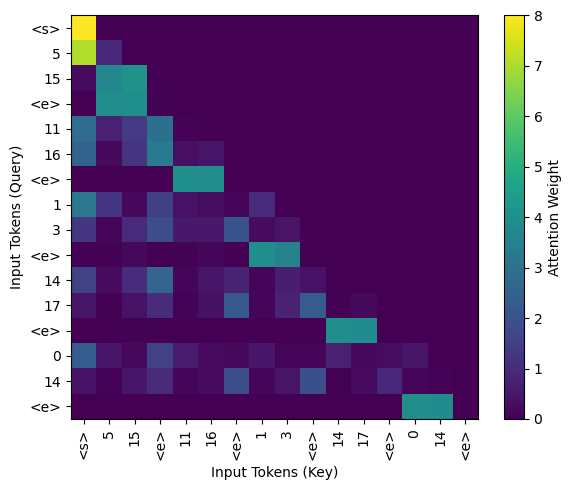

In [6]:
# print(outputs.attentions[1][0][head_idx][-1, :])

# draw an attention map
import matplotlib.pyplot as plt

# Get the attention map for the last layer and head

first_layer_attentions = outputs.attentions[0][0][:, :, :].sum(dim=0)
# layer, batch, head, source_seq_len, target_seq_len


print(first_layer_attentions.shape)
# 107 * 107

# Create a heatmap of the attention weights
n_show = 16
show_attention = first_layer_attentions[:n_show, :n_show]

plt.figure(figsize=(6, 5))
# show all the x and y labels
# x label rotate 90 degrees

inputs_ = inputs.replace("|", "<e>").replace("<eos>", "<s>")

plt.xticks(range(n_show), inputs_.split(" ")[:n_show])
plt.xticks(rotation=0)

plt.yticks(range(n_show), inputs_.split(" ")[:n_show])
# add labels for x and y
plt.xlabel('Input Tokens (Key)')
plt.ylabel('Input Tokens (Query)')


# rotate the x and y labels
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.imshow(show_attention.detach().cpu().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')

# tight
plt.tight_layout()

## Second Layer Attention

**Layer 2** is responsible for node expansion: at each step, the continuous thought attends to all outgoing edges from nodes that are currently reachable. To quantify this behavior, we compute the aggregated attention score received by each edge token triplet $(s, t, \langle e \rangle)$ across all heads when generating the $i$-th continuous thought. We categorize edges into four types:  
1. **Reachable** – edges whose source node is in the reachable set at step $i$;  
2. **Not Reachable** – source node is not yet reachable;  
3. **Frontier** – a subset of reachable edges whose source nodes lie on the current search frontier, i.e., exactly $i$ steps from the root;  
4. **Optimal** – a subset of frontier edges that lie along the optimal reasoning path.

We report group-wise means averaged over the test set. The model strongly concentrates its attention on **Reachable** edges, aligning with our theoretical construction. Interestingly, it also exhibits a bias toward the **Frontier** subset, possibly because the training objective encourages predicting frontier nodes at each step, while attention to previously explored nodes naturally decays. Furthermore, **Optimal** edges tend to receive higher attention scores, likely due to supervision from multi-stage training based on chain-of-thought (CoT) solutions.


In [44]:
def get_attn(question):
    input_ids = tokenizer.encode(question, add_special_tokens=False)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(model.base_causallm.device)
    attention_mask = torch.ones_like(input_ids).to(model.base_causallm.device)
    labels = torch.full_like(input_ids, -100).to(model.base_causallm.device)
    position_ids = torch.arange(input_ids.shape[1]).unsqueeze(0).to(model.base_causallm.device)
    outputs = model(input_ids, attention_mask, labels, position_ids)

    latent_indices = (
        input_ids == model.latent_token_id
    ).nonzero()  # (num_latent_tokens_in_the_batch, 2)

    latent_lists = [
        [idx[1].item() for idx in latent_indices if idx[0] == i]
        for i in range(input_ids.shape[0])
    ]  # bs, num_latent_tokens_in_the_instance (difference across the batch)

    max_n_latents = max([len(l) for l in latent_lists])

    next_compute_range = (0, input_ids.shape[1])
    inputs_embeds = model.embedding(input_ids)

    if max_n_latents > 0:
        next_compute_range = (0, latent_indices[:, 1].min().item())
        # before the earliest latent token position

    kv_cache = None

    for pass_idx in range(max_n_latents):

        if kv_cache == None:
            # first forward pass
            outputs = model.base_causallm(
                inputs_embeds=inputs_embeds[
                    :, next_compute_range[0] : next_compute_range[1], :
                ],
                attention_mask=attention_mask[
                    :, next_compute_range[0] : next_compute_range[1]
                ],
                position_ids=position_ids[
                    :, next_compute_range[0] : next_compute_range[1]
                ],
                output_hidden_states=True,
                output_attentions=True,
            )
            hidden_states_offset = 0

        else:
            # extract kv cache to reuse
            past_key_values = [
                (
                    k[:, :, : next_compute_range[0], :],
                    v[:, :, : next_compute_range[0], :],
                )
                for k, v in kv_cache
            ]

            outputs = model.base_causallm(
                inputs_embeds=inputs_embeds[
                    :, next_compute_range[0] : next_compute_range[1], :
                ],
                attention_mask=attention_mask[:, : next_compute_range[1]],
                position_ids=position_ids[
                    :, next_compute_range[0] : next_compute_range[1]
                ],
                past_key_values=past_key_values,
                output_hidden_states=True,
                output_attentions=True,
            )

            hidden_states_offset = next_compute_range[0]
            # when we use kv_cache for the first k tokens
            # in `outputs.hidden_states`, [0, k) will be skipped
            # so we need to keep this offset to correctly use the last hidden states

        # logits.append(outputs.logits)

        next_compute_range = (
            next_compute_range[1],
            (
                input_ids.shape[1]
                if pass_idx + 1 >= max_n_latents
                else next_compute_range[1] + 1
            ),
        )

        hidden_states = outputs.hidden_states[
            -1
        ]  # Get the last layer hidden states
        kv_cache = outputs.past_key_values

        # feedback the continuous thoughts to the input_embeds

        # first decide the positions to feedback
        filling_indices = [
            (instance_idx, mask_list[pass_idx])
            for instance_idx, mask_list in enumerate(latent_lists)
            if len(mask_list) > pass_idx
        ]

        # to avoid in-place operations
        # break down inputs_embeds (bs, len, hidden_size) into a list of list of 1-d tensors
        tensor_list = [
            [
                inputs_embeds[batch_idx, pos, :]
                for pos in range(inputs_embeds.shape[1])
            ]
            for batch_idx in range(inputs_embeds.shape[0])
        ]

        # replace some of them with continuous thoughts
        for idx_pair in filling_indices:
            batch_idx, token_idx = idx_pair

            # replace it with the preceding last hidden states
            tensor_list[batch_idx][token_idx] = hidden_states[
                batch_idx, token_idx - 1 - hidden_states_offset, :
            ]

        # assemble the new inputs_embeds
        inputs_embeds = torch.stack(
            [
                torch.stack(tensor_list[batch_idx])
                for batch_idx in range(inputs_embeds.shape[0])
            ]
        )
    # final pass
    final_outputs = model.base_causallm(
        inputs_embeds=inputs_embeds[
            :, next_compute_range[0] : next_compute_range[1], :
        ],
        attention_mask=attention_mask[:, : next_compute_range[1]],
        position_ids=position_ids[:, next_compute_range[0] : next_compute_range[1]],
        past_key_values=(
            [
                (
                    k[:, :, : next_compute_range[0], :],
                    v[:, :, : next_compute_range[0], :],
                )
                for k, v in kv_cache
            ]
            if kv_cache
            else None
        ),
        output_hidden_states=True,
        output_attentions=True,
    )

    # logits.append(final_outputs.logits)
    last_layer_attentions = final_outputs.attentions[1][0][:, -1, :]
    return last_layer_attentions

In [45]:
dataset = json.load(open("data/prosqa_test_graph_4_coconut.json"))

In [53]:
for n_step in range(0, 4):

    att_group_frontier = []
    att_group_within_k = []
    att_group_optimal = []
    att_group_invalid = []

    # show progress bar
    for data in tqdm(dataset):
        
        # data['neighbor_k'][str(n_step + 1)]
        
        if str(n_step + 1) not in data['neighbor_k']:
            continue
        
        symbol_to_idx = {}
        for i, s in enumerate(data['idx_to_symbol']):
            symbol_to_idx[s] = i
        
        random.shuffle(data['edges'])

        question = "<eos> " + "|".join([f" {e[0]} {e[1]} " for e in data['edges']]).strip() + \
            " [Q] "
        if random.random() < 0.5:
            question += str(data['target']) + " " + str(data['neg_target'])
        else:
            question += str(data['neg_target']) + " " + str(data['target'])

        question += " [R] " + str(data['root']) + " <|latent|>" * n_step

        last_layer_attentions = get_attn(question)

        
        # sum the attention weights of all the heads
        attn_sum = last_layer_attentions.sum(dim=0)
        # plot the sum
        # count the number of heads that have attention weights greater than 0.5
        
        current_node_set = [data['root']]
        
        reachable_node_set = set(current_node_set)
        
        for _ in range(n_step):
            next_node_set = []
            for node in current_node_set:
                for edge in data['edges']:
                    if edge[0] == node:
                        next_node_set.append(edge[1])
            current_node_set = next_node_set
            reachable_node_set.update(current_node_set)
        
        # find index of (root, neighbor) in the question
        for i in range(1, len(question.split(" ")), 3):
            if question.split(" ")[i + 2] != "|":
                break
            
            if int(question.split(" ")[i]) in reachable_node_set:
                
                att_group_within_k.append(attn_sum[i:i+3].sum().item())
            
                if int(question.split(" ")[i]) in current_node_set:
                    att_group_frontier.append(attn_sum[i:i+3].sum().item())
                    if int(question.split(" ")[i + 1]) in data['neighbor_k'][str(n_step + 1)]:
                        att_group_optimal.append(attn_sum[i:i+3].sum().item())
                    
            else:
                # print("invalid", i, question.split(" ")[i: i+3])
                att_group_invalid.append(attn_sum[i:i+3].sum().item())

        # break
        
    # draw a dist plot of att_group_valid and att_group_invalid
    # print(len(att_group_frontier), len(att_group_optimal), len(att_group_invalid))
    print(n_step)
    print("frontier", round(sum(att_group_frontier) / len(att_group_frontier), 4))
    print("optimal", round(sum(att_group_optimal) / len(att_group_optimal), 4))
    print("invalid", round(sum(att_group_invalid) / len(att_group_invalid), 4))
    print("within_k", round(sum(att_group_within_k) / len(att_group_within_k), 4))

100%|██████████| 419/419 [00:02<00:00, 187.00it/s]


0
frontier 1.8065
optimal 2.1848
invalid 0.0732
within_k 1.8065


100%|██████████| 419/419 [00:04<00:00, 96.96it/s]


1
frontier 0.7455
optimal 1.2767
invalid 0.071
within_k 0.5616


100%|██████████| 419/419 [00:06<00:00, 65.63it/s]


2
frontier 0.5061
optimal 1.2628
invalid 0.118
within_k 0.3161


100%|██████████| 419/419 [00:04<00:00, 96.83it/s] 

3
frontier 0.4542
optimal 1.6539
invalid 0.1529
within_k 0.2476


## Analysis of the continuous thoughts

**Representation of Continuous Thoughts**

To verify that continuous thoughts serve as superposition states for the search process, we compute the inner product between the continuous thought at step $i$, denoted $[t_i]$, and each node embedding $u_v$. As with edge classification, we categorize nodes into four groups:  
1. **Reachable** – nodes within the reachable set at step $i$;  
2. **Not Reachable** – nodes not yet reachable;  
3. **Frontier** – nodes exactly $i$ steps from the root (the current search frontier);  
4. **Optimal** – nodes on the optimal reasoning path.

The following code block shows the similarity distributions segmented by reasoning step $i$. As predicted, nodes within $i$ hops exhibit significantly higher similarity to $[t_i]$ than more distant nodes. Notably, **Frontier** nodes are even more similar to the thought vector than other reachable nodes, indicating that the superposition emphasizes candidate expansion fronts. **Optimal** nodes are closer still, likely due to training supervision consistently highlighting optimal paths.


In [46]:
# define the function to compute the continuous thoughts

def get_continuous_thoughts(question):
    input_ids = tokenizer.encode(question, add_special_tokens=False)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(model.base_causallm.device)
    attention_mask = torch.ones_like(input_ids).to(model.base_causallm.device)
    labels = torch.full_like(input_ids, -100).to(model.base_causallm.device)
    position_ids = torch.arange(input_ids.shape[1]).unsqueeze(0).to(model.base_causallm.device)
    outputs = model(input_ids, attention_mask, labels, position_ids)
    return outputs.inputs_embeds

In [47]:
# load the dataset
dataset = json.load(open("data/prosqa_test_graph_4_coconut.json"))

In [48]:
stats = {}

for n_step in range(0, 4):

    inner_prod_frontier = []
    inner_prod_within_k = []
    inner_prod_invalid = []
    inner_prod_optimal = []

    # Get token embeddings for comparison
    token_embeddings = model.embedding.weight

    for data in tqdm(dataset):
        if str(n_step + 1) not in data['neighbor_k']:
            continue
            
        # Construct question string
        question = "<eos> " + "|".join([f" {e[0]} {e[1]} " for e in data['edges']]).strip() + \
            " [Q] "
        if random.random() < 0.5:
            question += str(data['target']) + " " + str(data['neg_target'])
        else:
            question += str(data['neg_target']) + " " + str(data['target'])
        question += " [R] " + str(data['root']) + " <|latent|>" * (n_step + 1)
        # the last input embedding is the previous latent continuous thought

        # Get continuous thoughts embeddings
        continuous_embeds = get_continuous_thoughts(question)
        
        # Find positions of latent tokens
        input_ids = tokenizer.encode(question, add_special_tokens=False)
        latent_positions = [i for i, id in enumerate(input_ids) if id == latent_id]
        
        if len(latent_positions) == 0:
            continue
            
        # Get the last latent token's continuous thought
        last_latent_pos = latent_positions[-1]
        continuous_thought = continuous_embeds[0, last_latent_pos, :]
        
        # Compute inner products with all token embeddings
        inner_products = torch.matmul(continuous_thought, token_embeddings.t().to(continuous_thought.device))
        
        # Track current nodes for step n
        current_node_set = [data['root']]
        previous_node_set = []
        for _ in range(n_step + 1):
            previous_node_set += current_node_set
            next_node_set = []
            for node in current_node_set:
                for edge in data['edges']:
                    if edge[0] == node:
                        next_node_set.append(edge[1])
            current_node_set = next_node_set
        
        # Classify nodes and compute average inner products
        all_nodes = set()
        for edge in data['edges']:
            all_nodes.add(edge[0])
            all_nodes.add(edge[1])
            
        optimal_node_set = set(data['neighbor_k'][str(n_step + 1)])
        
        for node in all_nodes:
            node_token_id = tokenizer.encode(str(node), add_special_tokens=False)[0]
            inner_prod = inner_products[node_token_id].item()
            
            if node in current_node_set + previous_node_set:
                inner_prod_within_k.append(inner_prod)
                if node in current_node_set:
                    inner_prod_frontier.append(inner_prod)
                    if node in optimal_node_set:
                        inner_prod_optimal.append(inner_prod)
            else:
                inner_prod_invalid.append(inner_prod)

    # save the inner products
    stats[n_step] = {
        "step": n_step,
        "inner_prod_invalid": inner_prod_invalid,
        "inner_prod_within_k": inner_prod_within_k,
        "inner_prod_frontier": inner_prod_frontier,
        "inner_prod_optimal": inner_prod_optimal
    }

100%|██████████| 419/419 [00:02<00:00, 159.63it/s]


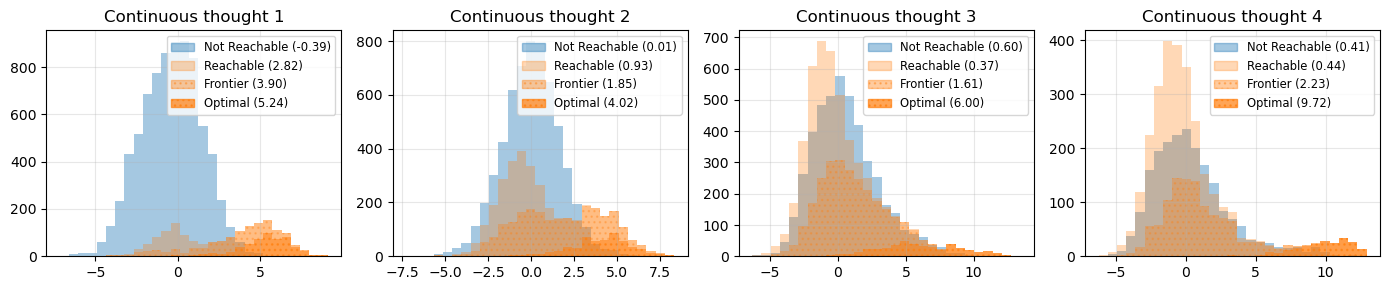

In [49]:
# Create a 2x4 subplot layout
fig, axes = plt.subplots(1, 4, figsize=(14, 3), sharey=False)

# First row: Original model
for step in range(4):
    # Load data for each step
    
    data = stats[step]
    # Extract data
    inner_prod_invalid = data['inner_prod_invalid']
    inner_prod_within_k = data['inner_prod_within_k']
    inner_prod_frontier = data['inner_prod_frontier']
    inner_prod_optimal = data['inner_prod_optimal']
    
    # Calculate means
    mean_invalid = np.mean(inner_prod_invalid)
    mean_within_k = np.mean(inner_prod_within_k)
    mean_frontier = np.mean(inner_prod_frontier)
    mean_optimal = np.mean(inner_prod_optimal)
    
    # Define common bins for this subplot
    bins = np.linspace(
        min(min(inner_prod_invalid), min(inner_prod_within_k)),
        max(max(inner_prod_invalid), max(inner_prod_within_k)),
        30
    )
    
    # Plot on current subplot
    ax = axes[step]
    
    # ax.set_xlabel('Inner Product Value')
    
    ax.hist(inner_prod_invalid, bins=bins, alpha=0.4, 
            label=f'Not Reachable ({mean_invalid:.2f})',
            color='C0', edgecolor='C0', histtype='stepfilled', linewidth=0)
    
    ax.hist(inner_prod_within_k, bins=bins, alpha=0.3, 
            label=f'Reachable ({mean_within_k:.2f})',
            color='C1', edgecolor='C1', histtype='stepfilled', linewidth=0)
    
    ax.hist(inner_prod_frontier, bins=bins, alpha=0.3, 
            label=f'Frontier ({mean_frontier:.2f})',
            color='C1', histtype='bar',
            hatch='...', edgecolor='C1', linewidth=0)
    
    ax.hist(inner_prod_optimal, bins=bins, alpha=0.5, 
            label=f'Optimal ({mean_optimal:.2f})',
            color='C1', histtype='bar',
            hatch='...', edgecolor='C1', linewidth=0)
    
    ax.set_title(f'Continuous thought {step + 1}')
    ax.grid(alpha=0.3)
    
    # Only add x-label for bottom row
    
    ax.set_title(f'Continuous thought {step + 1}')
    
    # Show legend for all subplots with smaller font size
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(color='C0', alpha=0.4, label=f'Not Reachable ({mean_invalid:.2f})'),
        Patch(color='C1', alpha=0.3, label=f'Reachable ({mean_within_k:.2f})'),
        Patch(color='C1', alpha=0.4, hatch='...', label=f'Frontier ({mean_frontier:.2f})'),
        Patch(color='C1', alpha=0.7, hatch='...', label=f'Optimal ({mean_optimal:.2f})')  # Higher alpha for optimal
    ]
    ax.legend(handles=legend_elements, fontsize='small', loc='upper right')

plt.tight_layout()

plt.show()

Together, these findings confirm that trained models implement a soft, parallel search mechanism through superpositional reasoning: **Layer 1** establishes the query context, **Layer 2** expands the search frontier, and the latent vectors encode reachable state sets in a continuous, distributed form—realizing the theoretical construction in the paper.